# Exploring interaction effects with logistic regression

After we train a logistic regression, we can look at the coefficients table to get an idea of how each individual predictor variable contributes to the outcome of the objective variable. For example, a large, positive coefficient indicates that the predictor greatly increases the log odds of the outcome. However, such an interpretation is under the assumption that the predictor variables act independently of each other. In many real-world cases, the value of one predictor will influence how another predictor contributes to the objective.

In this notebook, we'll explore how to identify and quantify these interaction effects. The procedure followed here is also explained in Chapter 3 of the book [Applied Logistic Regression](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470582472.html) by Hosmer, Lemeshow, and Sturdivant. We have adapted that workflow to use the [BigML Python bindings](http://bigml.readthedocs.io/en/latest/).

## The Data

The data we will use in this example is the Wine Quality dataset, which is available in the UCI Machine Learning Dataset Repository [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). Each row in this dataset contains physicochemical measurements from a particular sample of wine, along with a preference score assigned to that sample by a taster. Some minimal preprocessing was performed on the data. Specifically:

- The original dataset is split into two CSV files for red (1599 instances), and white (4898 instances) wines. We concatenate the two CSV files to obtain a single dataset with 6497 instances. In addition we add a Categorical field called "type", which takes on the value 0 for white wines and 1 for red wines.
- The original quality field is integer-valued betwee 0-10. We created an additional binary-valued field called "good wine" which is 1 if the quality is greater than or equal to 5, and 0 otherwise.


Our analysis will be confined to two predictor variables:

- Citric Acid: The wine's citric acid content in $\textrm{g/dm}^3$. Numeric.
- Type: Red or White wine. Categorical 0 = White, 1 = Red.

We will model how these two predictors affect the probabiltiy of our objective:

- Good Wine: Whether the wine received a quality score >= 5. Categorical 0 = No, 1 = Yes.

## Setup

To begin, we will import the BigML Python bindings, matplotlib for plotting, and a couple utility functions for handling logistic regression coefficients. We'll also create a BigML project to keep our resources organized.

In [1]:
from bigml.api import BigML
import matplotlib
from matplotlib import pyplot
from numpy import *
from myutils import print_coeff_table

%matplotlib inline
matplotlib.rcParams['font.size'] = 16

api = BigML()

prj = api.create_project({'name' : 'lr-interactions'})
prj = prj['resource']

## Dataset Creation

Now we will upload the CSV file containing the NHANES data to BigML, and create a dataset. We will then split the dataset 80/20 into training and test sets for later evaluation. Using a fixed seed ensures that we get complementary samples.

In [2]:
src = api.create_source('winequality-all.csv', {'project' : prj})

origin_dataset = api.create_dataset(src, {'project': prj})

training_dataset = api.create_dataset(origin_dataset, {'project' : prj,
                                                       'name' : 'Wine Quality Training Set',
                                                       'sample_rate' : 0.8,
                                                       'seed' : 'example-seed'})
test_dataset = api.create_dataset(origin_dataset, {'project' : prj,
                                                   'name' : 'Wine Quality Test Set',
                                                   'sample_rate' : 0.8,
                                                   'out_of_bag' : True,
                                                   'seed' : 'example-seed'})
api.ok(training_dataset)

True

## Model 1 - type only

Our first logistic regression model will assess what effect being a red wine (`type` = 1) has on receiving a good quality score (`good wine` = 1). We will code the categorical field `type` with dummy coding, with 0 as the dummy value. As a result we will obtain only one coefficient which gives the odds of `good wine=1` with `type=1`, compared to `type=0`.

In [3]:
lr_opts = {'project' : prj, 'objective_field' : 'good wine', 
           'field_codings' : [{'field' : 'type', 'coding' : 'dummy', 
                               'dummy_class' : '0'}], 
           'balance_fields' : False,
           'input_fields' : ['type'],
           'name' : 'Wine quality logistic regression - type only'}

lr1 = api.create_logistic_regression(training_dataset, lr_opts)
api.ok(lr1)
coeffs1,pvals1,confs1 = print_coeff_table(lr1)


Predictor		 Coefficient	 p-value	 95% Confidence Interval
--------------------------------------------------------------------------------
Intercept		 0.66944	 0.00000	 [0.60299, 0.73590]
type			 -0.53509	 0.00000	 [-0.66226, -0.40792]


The coefficient for `type` is significant ($p < 0.05$), and negative, meaning that `type` is negatively associated with `good wine`. The log odds of `good wine` is given by the following logit:

\begin{equation}
\ln(o) = \beta_0 + \beta_1 x_1
\end{equation}

Where $x_1$ is the variable corresponding to `type`, taking on values 0 or 1. We might ask how much less likely a good score is to be awarded, given that a red wine is being tested. We can compute the *odds ratio* like so:

\begin{equation}
OR = \frac{o_1}{o_1}\qquad \textrm{or} \qquad \ln(OR) = \ln(o_1) - \ln(o_0)
\end{equation}

In [4]:
log_o1 = coeffs1[0] + coeffs1[1]*1
log_o0 = coeffs1[0] + coeffs1[1]*0
log_or = log_o1 - log_o0
odds_ratio = exp(log_or)
print(odds_ratio)

0.585615359156


In other words, the odds for red wines to receive good quality scores is less than 60% as likely as the odds for white wines. We can also see this by computing the explicit probability of a good score, which is given by the logistic function:

\begin{equation}
P = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 x_1))} 
\end{equation}

In terms of probabilities the odds ratio is defined as:

\begin{equation}
OR = \frac{\frac{P_1}{(1 - P_1)}}{\frac{P_0}{(1 - P_0)}}
\end{equation}

In [5]:
p1 = 1 / (1 + exp(-log_o1))
print(p1)

0.53353777006


In [6]:
p0 = 1 / (1 + exp(-log_o0))
print(p0)

0.661378852184


In [7]:
odds_ratio_by_probs = (p1/(1-p1)) / (p0/(1-p0))
print(odds_ratio_by_probs)

0.585615359156


## Model 2 - type + citric acid

We will now add a second predictor, citric acid, to our logistic regression model:

In [8]:
lr_opts['input_fields'].append('citric acid')
lr_opts['name'] = 'Wine Quality Logistic Regression - type + citric acid'
lr2 = api.create_logistic_regression(training_dataset,lr_opts)
api.ok(lr2)
coeffs2,pvals2,confs2 = print_coeff_table(lr2)


Predictor		 Coefficient	 p-value	 95% Confidence Interval
--------------------------------------------------------------------------------
Intercept		 0.44427	 0.00000	 [0.29691, 0.59163]
type			 -0.49400	 0.00000	 [-0.62365, -0.36435]
citric acid		 0.67764	 0.00083	 [0.28042, 1.07485]


Again, the log-odds for `good score` is given by a logit:
    
\begin{equation}
\ln(o) = \beta_0 + \beta_1 x_1 + \beta_2 x_2
\end{equation}

We now have a second coefficient corresponding to the predictor variable $x_2$: the concentration of citric acid in the wine. Let's look at the log-odds as a function of citric acid, for both red and white wines:


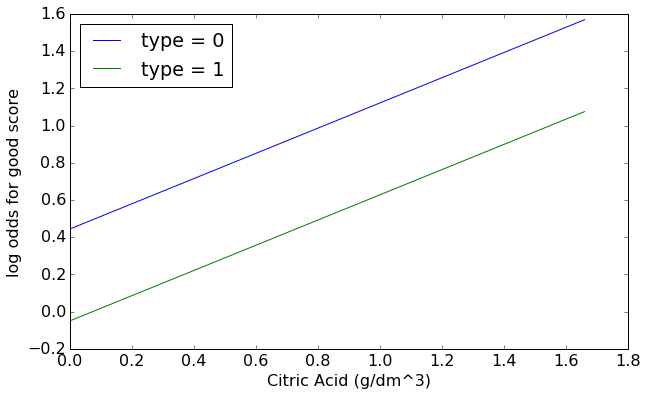

In [9]:
# evaluate the logit function at type = 0 and type = 1 for a range of citric acid values
xvals = linspace(0.0,1.66)
log_odds_0 = coeffs2[0] + coeffs2[1]*0 + coeffs2[2]*xvals
log_odds_1 = coeffs2[0] + coeffs2[1]*1 + coeffs2[2]*xvals

# plot the results
pyplot.figure(figsize=(10,6))
pyplot.plot(xvals,log_odds_0)
pyplot.plot(xvals,log_odds_1)
pyplot.xlabel('Citric Acid (g/dm^3)')
pyplot.ylabel('log odds for good score')
pyplot.legend(['type = 0', 'type = 1'],loc='upper left')

Although different combinations of `type` and `citric acid` will result in different values for the log-odds, this plot shows that the two predictors in this model are *independent* of each other. Specifically, the log-odds is a linear function of citric acid, and the slope of that function is the same for both values of `type`. This shows that the effect of `citric acid` on the log-odds is independent of `type`. At the same time, for any value of `citric acid`, the vertical distance between the two lines is the same, showing that the effect of `type` on the log-odds is independent of `citric acid`.

There are many cases when this independence assumption does not faithfully model the behavior of the data. To see whether that might be the case here, we will see how much the value of the `type` coefficient changed through the addition of `citric acid` as a predictor:

In [10]:
delta_b1 = abs((coeffs2[1] - coeffs1[1]) / coeffs2[1])
print(delta_b1)

0.08318532814552569


With a change of nearly 10%, we are justified in believing that there may be *interaction effects* between the two predictor variables. Our third logistic regression model will investigate this hypothesis.

## Model 3 - type + citric acid with Interaction

To model interaction effects, we will extend our training dataset with an additional field containing an interaction term. Interaction terms are simply the product of the values of two predictor variables. We apply the same extension to the test dataset for later evaluation.

In [11]:
flatline_str = '(* (f "citric acid") (integer (f type)))'
training_ds_extended = api.create_dataset(training_dataset, {'new_fields':[{'field' : flatline_str,
                                                             'name' : 'citric acid*type'}]})
test_ds_extended = api.create_dataset(test_dataset, {'new_fields':[{'field' : flatline_str,
                                                                     'name' : 'citric acid*type'}]})
api.ok(training_ds_extended)

True

Now, we will train a logistic regression with the two predictors `type` and `citric acid`, and their interaction term `citric acid*type`.

In [12]:
lr_opts['input_fields'].append('citric acid*type')
lr_opts['name'] = 'Wine Quality Logistic Regression: type + citric acid + interaction'
lr3 = api.create_logistic_regression(training_ds_extended,lr_opts)
api.ok(lr3)

coeffs3,pvals3,confs3 = print_coeff_table(lr3)


Predictor		 Coefficient	 p-value	 95% Confidence Interval
--------------------------------------------------------------------------------
Intercept		 0.64898	 0.00000	 [0.45381, 0.84415]
type			 -0.88613	 0.00000	 [-1.15713, -0.61513]
citric acid		 0.06009	 0.83021	 [-0.48915, 0.60933]
citric acid*type	 1.31815	 0.00111	 [0.52613, 2.11018]


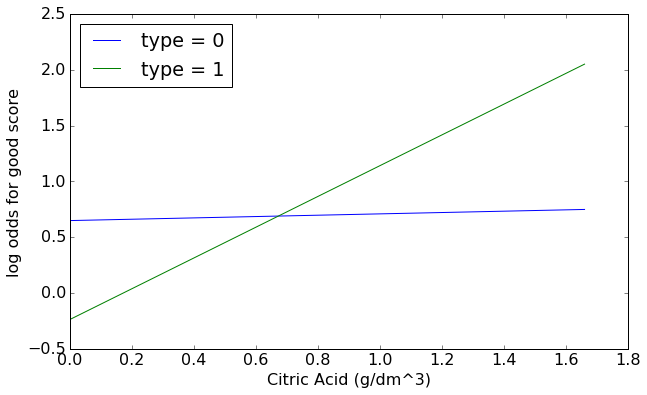

In [13]:
log_odds_0 = coeffs3[0] + coeffs3[1]*0 + coeffs3[2]*xvals + coeffs3[3]*0*xvals
log_odds_1 = coeffs3[0] + coeffs3[1]*1 + coeffs3[2]*xvals + coeffs3[3]*1*xvals

# plot the results
pyplot.figure(figsize=(10,6))
pyplot.plot(xvals,log_odds_0)
pyplot.plot(xvals,log_odds_1)
pyplot.xlabel('Citric Acid (g/dm^3)')
pyplot.ylabel('log odds for good score')
pyplot.legend(['type = 0', 'type = 1'],loc='upper left')

The graph here is drastically different from the one for the independent logistic regression model. We can see that for both types of wine, the odds for `good wine` continue to be positively correlated with `citric acid`, but the impact is much greater for red wines compared to white wines. In fact, if we look at the p-values in the coefficient table, we see that the interaction term between `type` and `citric acid` is significant, but the one for `citric acid` alone is no longer significant. From this, we can conclude that `citric acid` is a significant predictor of quality only for red wines.

## Evaluations

Now we will take our three logistic regression models, evaluate them against our 20% holdout test set, and plot their average F-measures.

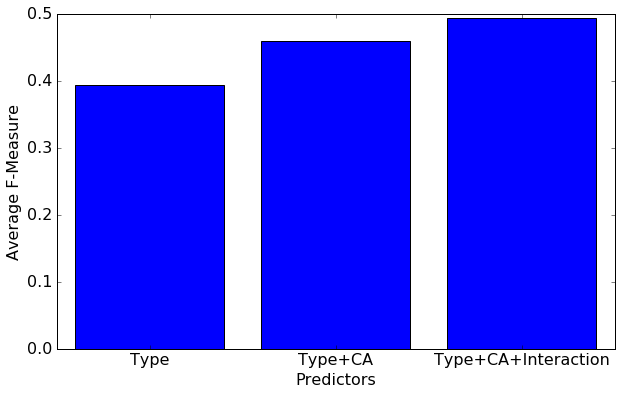

In [14]:
eval1 = api.create_evaluation(lr1,test_ds_extended)
eval2 = api.create_evaluation(lr2,test_ds_extended)
eval3 = api.create_evaluation(lr3,test_ds_extended)

api.ok(eval1)
api.ok(eval2)
api.ok(eval3)

f1,f2,f3 = [e['object']['result']['model']['average_f_measure'] for e in [eval1,eval2,eval3]]

pyplot.figure(figsize=(10,6))
pyplot.bar([1,2,3],[f1,f2,f3],align='center')
pyplot.xticks([1,2,3],['Type', 'Type+CA', 'Type+CA+Interaction'])
pyplot.xlabel('Predictors')
pyplot.ylabel('Average F-Measure')

Our results show that the model which includes the interaction term achieves the best classification performance. In conclusion, not only does identifying interactions between predictor variables give a deeper insight into the behavior of your data, but it can produce better models for predictive applications too.

In [15]:
# uncomment and run this cell to clean up resources generated by this notebook

#for p in api.list_projects('name=lr-interactions')['objects']:
#        api.delete_project(p)